In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
from scipy.io import mmread

In [2]:
# n - population size
# k - number of communities
# c - average degree
# e - strength of community
def planted_partition_graph(n, k, c, e):
    p_in = (2*c + e)/(2*n)
    p_out = (2*c - e)/(2*n)
    
    G = nx.planted_partition_graph(k, n // k, p_in, p_out)
    
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'pink', 'brown']
    
    # Add color attributes to nodes
    for i in range(k):
        community_nodes = range(i * (n // k), (i + 1) * (n // k))
        community_color = colors[i % len(colors)]
        nx.set_node_attributes(G, {node: community_color for node in community_nodes}, name='color')
        
    return G

note e can range from 0 (no communities) to 2c (completely seperate communities)

### Constructing the facebook network

In [3]:
# e=50 to give a fairly high level of modularity
fb = planted_partition_graph(500, 10, 30, 50)

# Create copy of netowrk for random political assignment
fb_random = fb.copy()

In [4]:
fb.nodes(data=True)

NodeDataView({0: {'block': 0, 'color': 'blue'}, 1: {'block': 0, 'color': 'blue'}, 2: {'block': 0, 'color': 'blue'}, 3: {'block': 0, 'color': 'blue'}, 4: {'block': 0, 'color': 'blue'}, 5: {'block': 0, 'color': 'blue'}, 6: {'block': 0, 'color': 'blue'}, 7: {'block': 0, 'color': 'blue'}, 8: {'block': 0, 'color': 'blue'}, 9: {'block': 0, 'color': 'blue'}, 10: {'block': 0, 'color': 'blue'}, 11: {'block': 0, 'color': 'blue'}, 12: {'block': 0, 'color': 'blue'}, 13: {'block': 0, 'color': 'blue'}, 14: {'block': 0, 'color': 'blue'}, 15: {'block': 0, 'color': 'blue'}, 16: {'block': 0, 'color': 'blue'}, 17: {'block': 0, 'color': 'blue'}, 18: {'block': 0, 'color': 'blue'}, 19: {'block': 0, 'color': 'blue'}, 20: {'block': 0, 'color': 'blue'}, 21: {'block': 0, 'color': 'blue'}, 22: {'block': 0, 'color': 'blue'}, 23: {'block': 0, 'color': 'blue'}, 24: {'block': 0, 'color': 'blue'}, 25: {'block': 0, 'color': 'blue'}, 26: {'block': 0, 'color': 'blue'}, 27: {'block': 0, 'color': 'blue'}, 28: {'block': 0,

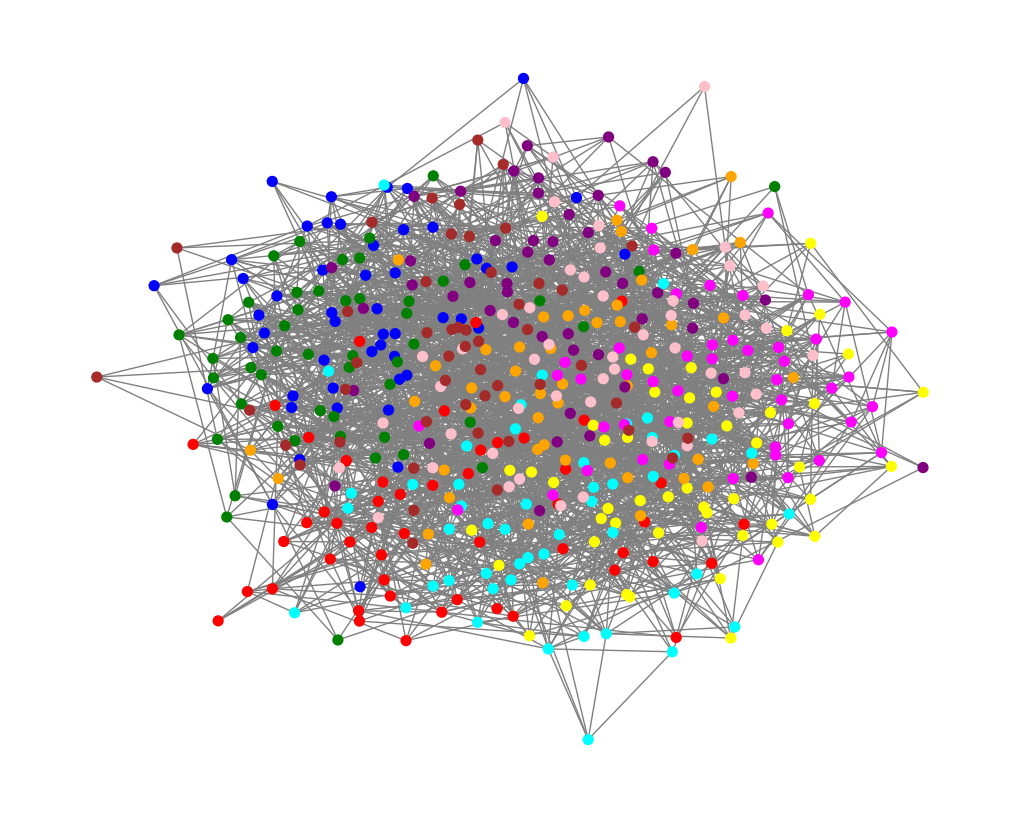

In [5]:
node_colors = [data['color'] for node, data in fb.nodes(data=True)]

plt.figure(figsize=(10, 8))
nx.draw(fb, node_color=node_colors, node_size=50, edge_color='gray')
plt.show()

Attempting non-random assignment of political ranking (at some point this should all be wrapped into a function)

In [6]:
fb.nodes(data=True)

NodeDataView({0: {'block': 0, 'color': 'blue'}, 1: {'block': 0, 'color': 'blue'}, 2: {'block': 0, 'color': 'blue'}, 3: {'block': 0, 'color': 'blue'}, 4: {'block': 0, 'color': 'blue'}, 5: {'block': 0, 'color': 'blue'}, 6: {'block': 0, 'color': 'blue'}, 7: {'block': 0, 'color': 'blue'}, 8: {'block': 0, 'color': 'blue'}, 9: {'block': 0, 'color': 'blue'}, 10: {'block': 0, 'color': 'blue'}, 11: {'block': 0, 'color': 'blue'}, 12: {'block': 0, 'color': 'blue'}, 13: {'block': 0, 'color': 'blue'}, 14: {'block': 0, 'color': 'blue'}, 15: {'block': 0, 'color': 'blue'}, 16: {'block': 0, 'color': 'blue'}, 17: {'block': 0, 'color': 'blue'}, 18: {'block': 0, 'color': 'blue'}, 19: {'block': 0, 'color': 'blue'}, 20: {'block': 0, 'color': 'blue'}, 21: {'block': 0, 'color': 'blue'}, 22: {'block': 0, 'color': 'blue'}, 23: {'block': 0, 'color': 'blue'}, 24: {'block': 0, 'color': 'blue'}, 25: {'block': 0, 'color': 'blue'}, 26: {'block': 0, 'color': 'blue'}, 27: {'block': 0, 'color': 'blue'}, 28: {'block': 0,

In [7]:
unique_blocks = set()

# Iterate over nodes in the graph and collect unique values of 'block' attribute
for node in fb.nodes:
    unique_blocks.add(fb.nodes[node]['block'])
    
num_unique_blocks = len(unique_blocks)

rank = [-2, -1, 0, 1, 2]
block_weight = {}

random.shuffle(rank)

# Assign ranks to blocks in a round-robin fashion
for i in range(num_unique_blocks):
    block_weight[i] = rank[i % len(rank)]
    
block_weight

lists_dict = {} 
for i in range(num_unique_blocks):
    list_name = i  # Dynamically generate the list name
    lists_dict[list_name] = []  # Create an empty list with the dynamic name

for name, lst in lists_dict.items():
    lst.extend(rank)
    # Add 10 more iterations of the preffered rank for this block
    # THIS MAKES IT 10 TIMES MORE LIKELY THAT A NODE WILL BE GIVEN THE POLITICAL RANK OF THEIR GROUP
    for x in range(10):
        lst.append(block_weight[name])


In [8]:
block_weight

{0: -2, 1: 0, 2: 2, 3: 1, 4: -1, 5: -2, 6: 0, 7: 2, 8: 1, 9: -1}

In [9]:
lists_dict

{0: [-2, 0, 2, 1, -1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
 1: [-2, 0, 2, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2: [-2, 0, 2, 1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 3: [-2, 0, 2, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 4: [-2, 0, 2, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 5: [-2, 0, 2, 1, -1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
 6: [-2, 0, 2, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 7: [-2, 0, 2, 1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 8: [-2, 0, 2, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 9: [-2, 0, 2, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}

In [10]:
# Now assign political ranking to each node based on the relevant weighted list
for node in fb.nodes:
    block = fb.nodes[node]['block']
    fb.nodes[node]['politics'] = random.choice(lists_dict[block])

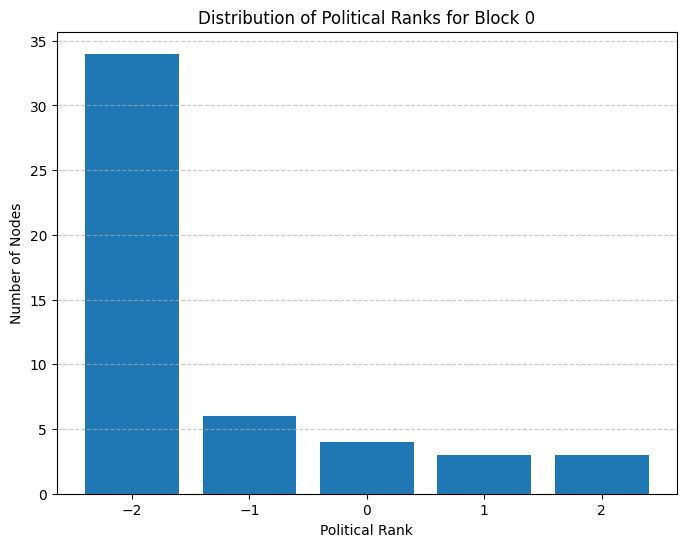

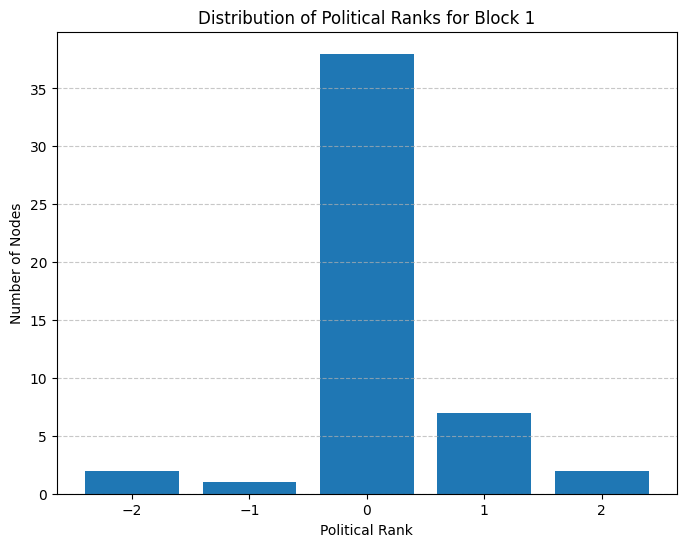

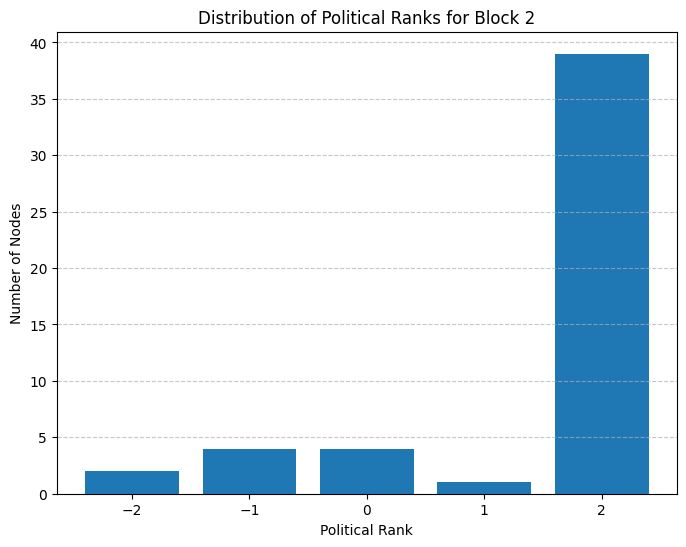

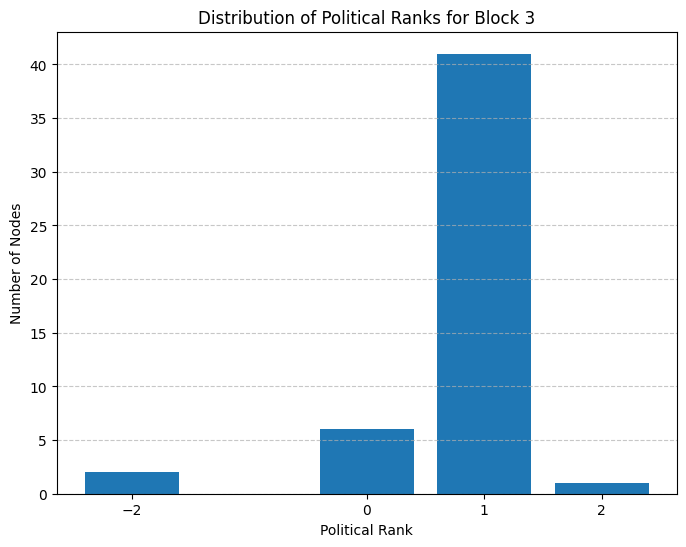

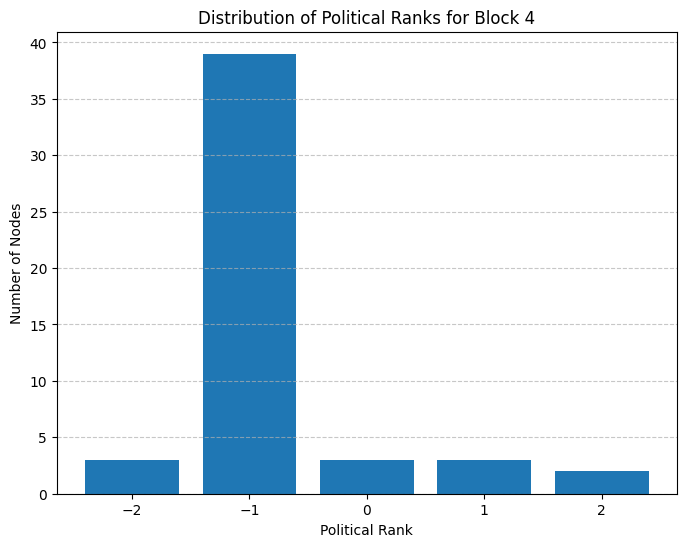

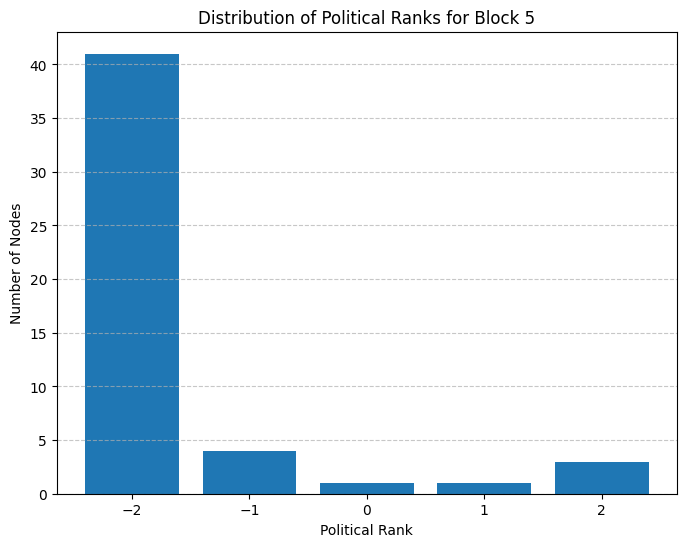

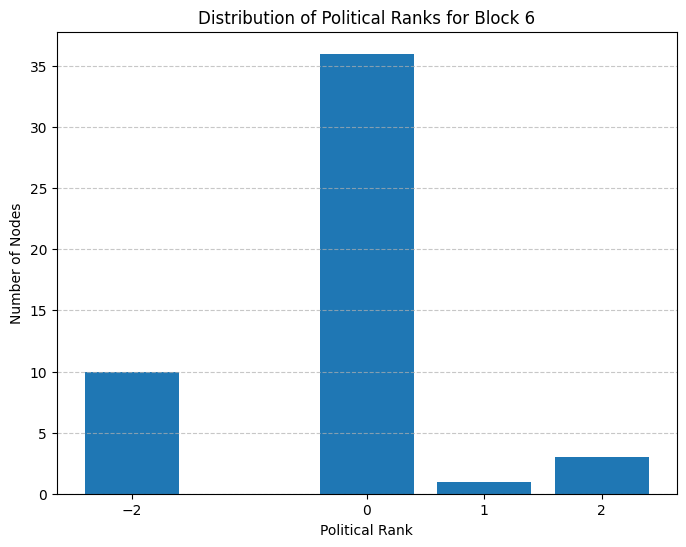

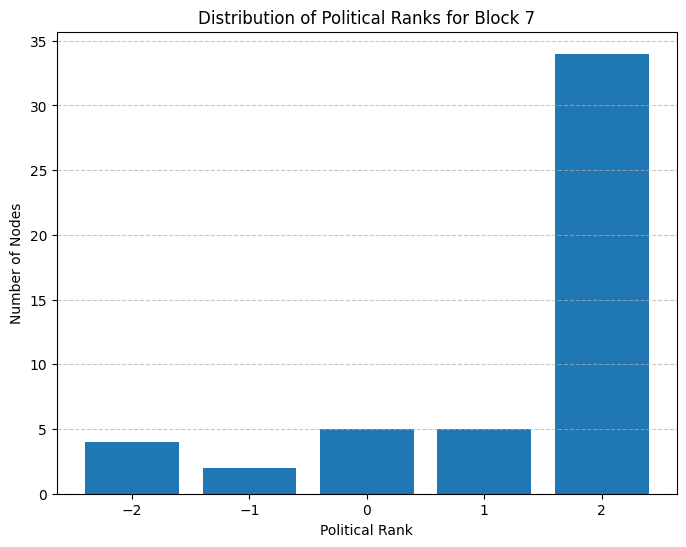

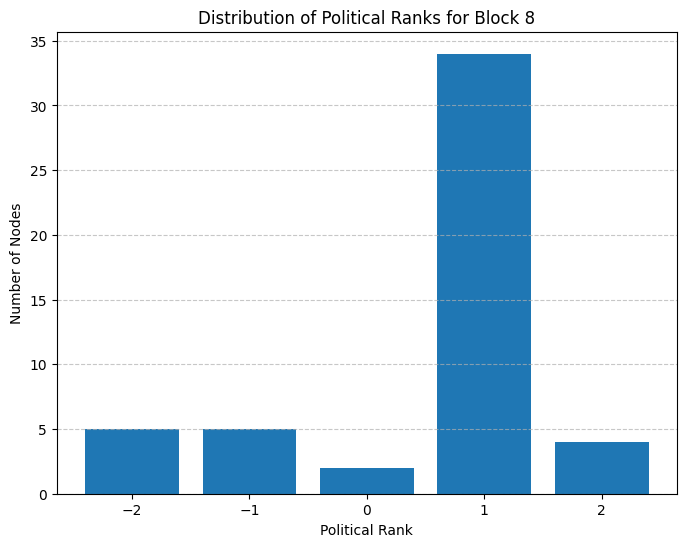

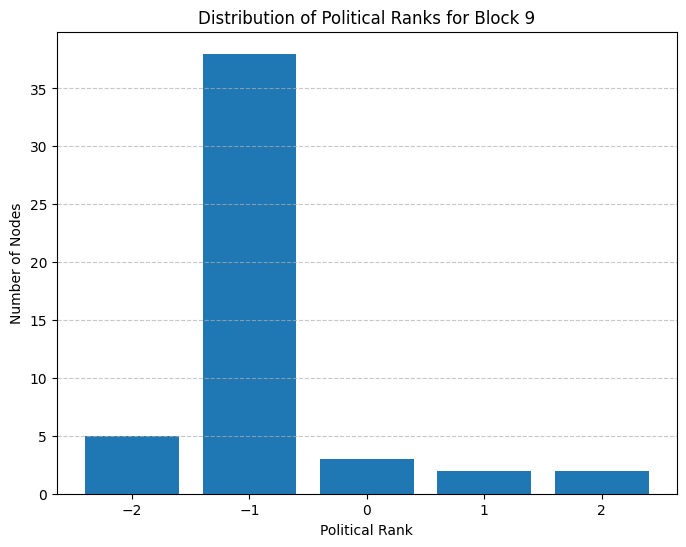

In [11]:
# Code to check the distribution of political ranking for each block

block_politics_count = {}

# Iterate over nodes and count the occurrences of political ranks for each block
for node in fb.nodes:
    block = fb.nodes[node]['block']
    politics = fb.nodes[node]['politics']
    
    if block not in block_politics_count:
        block_politics_count[block] = {}
    
    if politics not in block_politics_count[block]:
        block_politics_count[block][politics] = 1
    else:
        block_politics_count[block][politics] += 1

# Plot a bar chart for each block
for block, counts in block_politics_count.items():
    ranks = list(counts.keys())
    counts = list(counts.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(ranks, counts)
    plt.xlabel('Political Rank')
    plt.ylabel('Number of Nodes')
    plt.title(f'Distribution of Political Ranks for Block {block}')
    plt.xticks(ranks)  # Ensure all ranks are displayed on x-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [12]:
# Political ranking randomised for now but needs to be related to the community structure somehow
rank = [-2, -1, 0, 1, 2]
for node in fb_random.nodes:
    fb_random.nodes[node]['politics'] = random.choice(rank)

### Constructing the twitter network

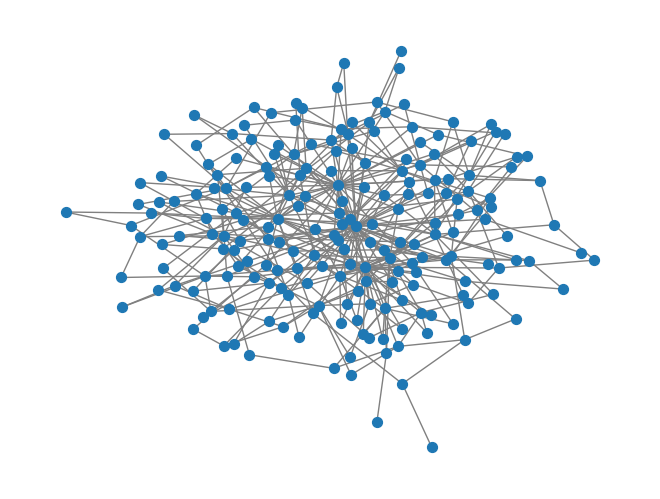

In [44]:
# Using a preferential attachment model
G = nx.barabasi_albert_graph(200, 2, seed=42)

for i in range(5):
    G.add_edge(200 + i, random.choice(list(G.nodes)))
    
    
nx.draw(G, node_size=50, edge_color='gray')

### Contagion model

In [13]:
# Function to determine probability of infection for a node given the politics and the mis_count

def infection_prob(politics, mis_count):
    probabilities = {-2: 0.01, -1: 0.10, 0: 0.20, 1: 0.50, 2: 0.75}
    
    adjusted_probabilities = {}
    for politics_val, prob in probabilities.items():
        adjusted_prob = prob - (mis_count * 0.003)
        
        # Ensure probability does not go below 0
        adjusted_prob = max(0, adjusted_prob)
        adjusted_probabilities[politics_val] = adjusted_prob
    
    # Return probability based on opinion
    return adjusted_probabilities[politics]

In [14]:
# Function currently works with people not being able to reshare. The simulation then stops in a period when no-one reshares
# Function will return the graph, where the infection status of the nodes will be an attribute
# Mis_count is currently handled sequentially (i.e. there will be different mis_count for different nodes in the same period). This needs to be considered.

def fake_news_spread(G, missing_count = True):
    
    # Set all nodes to uninfected
    for node in G.nodes:
        G.nodes[node]['infected'] = False
    
    infected_nodes = set()
    t = 1
    mis_count = 0
    
    # Set to keep track of nodes who have added to misleading count
    mis_count_nodes = set()
    
    # Define probabilities of adding to misleading count
    mis_probs = {-2: 0.8, -1: 0.6, 0: 0.5, 1: 0.25, 2: 0.1}
    
    # Choose one node with politics=2 randomly to start the spread
    nodes_politics_2 = [node for node, attrs in G.nodes(data=True) if attrs['politics'] == 2]
    random_node = random.choice(nodes_politics_2)
    infected_nodes.add(random_node)
    G.nodes[random_node]['infected'] = True
    
    # Iterate over time periods until no new person spreads fake news
    new_infections = set()
    new_infections.add(random_node)
    while True:
        t += 1

        # Defining sets as new_infections cannot be updated during the loop
        nodes_to_remove = set()
        nodes_to_add = set()
        
        # Iterate over infected nodes and infect their neighbors with some probability defined by previous function
        for node in new_infections:
            # Remove node from infections so each node only has one chance to spread fake news
            nodes_to_remove.add(node)
            for neighbor in G.neighbors(node):
                if neighbor not in infected_nodes and neighbor not in new_infections:
                    p = infection_prob(G.nodes[neighbor]['politics'], mis_count)
                    if random.random() < p:
                        nodes_to_add.add(neighbor)
                        G.nodes[neighbor]['infected'] = True
                    # Else condition to see if they add to misleading count
                    elif missing_count:
                        if neighbor not in mis_count_nodes:
                            mis_p = mis_probs[G.nodes[neighbor]['politics']]
                            if random.random() < mis_p:
                                mis_count += 1
                                mis_count_nodes.add(neighbor)
        
        # Remove all nodes which have shared fake news (as only one shot to infect)                
        new_infections.difference_update(nodes_to_remove)
        new_infections.update(nodes_to_add)
        infected_nodes.update(nodes_to_add)
                              
        if not new_infections:
            break
            
        infected_nodes.update(new_infections)
        
    print("Simulation lasted " + str(t) + " periods")
    if missing_count:
        print("Missing count at end of simulation: " + str(mis_count))
        print("Missing count (proportion of network): " + str(mis_count/len(G)))
    print("Number of people sharing fake news: " + str(len(infected_nodes)))
    print("Proportion of people sharing fake news: " + str(len(infected_nodes)/len(G)))
    
    return G

In [15]:
# Test on facebook graph with policy
fb_policy = fake_news_spread(fb)

Simulation lasted 8 periods
Missing count at end of simulation: 228
Missing count (proportion of network): 0.456
Number of people sharing fake news: 103
Proportion of people sharing fake news: 0.206


In [16]:
# Test on random facebook graph with policy
fb_random_policy = fake_news_spread(fb_random)

Simulation lasted 7 periods
Missing count at end of simulation: 198
Missing count (proportion of network): 0.396
Number of people sharing fake news: 72
Proportion of people sharing fake news: 0.144


In [17]:
# Test on facebook graph without policy
fb_no_policy = fake_news_spread(fb, missing_count=False)

Simulation lasted 12 periods
Number of people sharing fake news: 309
Proportion of people sharing fake news: 0.618


In [18]:
# Test on random facebook graph without policy
fb_random_no_policy = fake_news_spread(fb_random, missing_count=False)

Simulation lasted 13 periods
Number of people sharing fake news: 296
Proportion of people sharing fake news: 0.592


    WOULD BE INTERESTING TO PLOT THE GRAPH BASED ON INFECTION, SO WE CAN SEE WHICH OF THE DIFFERENT GROUPS ARE INFECTED MOST

Even in this example, we can say that if a plus one on the misleading count leads to a reduction in probability of sharing fake news of 0.2%, we still see a fairly drastic decrease in the number of people sharing fake news on facebook.

### Implementation on real data

In [27]:
a = mmread("C:/Users/gatla/OneDrive/BSE/Networks_1/socfb-American75/socfb-American75.mtx")
fb_real = nx.Graph(a)

In [29]:
# Randomise political ranking in facebook graph
rank = [-2, 1, 0, 1, 2]
for node in fb_real.nodes:
    fb_real.nodes[node]['politics'] = random.choice(rank)

In [30]:
fb_real.nodes(data=True)

NodeDataView({0: {'politics': 0}, 1: {'politics': -2}, 2: {'politics': 2}, 3: {'politics': -2}, 4: {'politics': 1}, 5: {'politics': 1}, 6: {'politics': 1}, 7: {'politics': 2}, 8: {'politics': 2}, 9: {'politics': -2}, 10: {'politics': 2}, 11: {'politics': 2}, 12: {'politics': 1}, 13: {'politics': 0}, 14: {'politics': 1}, 15: {'politics': -2}, 16: {'politics': 0}, 17: {'politics': 1}, 18: {'politics': 0}, 19: {'politics': 0}, 20: {'politics': 0}, 21: {'politics': 2}, 22: {'politics': 1}, 23: {'politics': 1}, 24: {'politics': 1}, 25: {'politics': 1}, 26: {'politics': 1}, 27: {'politics': 1}, 28: {'politics': -2}, 29: {'politics': 1}, 30: {'politics': 1}, 31: {'politics': 0}, 32: {'politics': -2}, 33: {'politics': 1}, 34: {'politics': 1}, 35: {'politics': 2}, 36: {'politics': 0}, 37: {'politics': -2}, 38: {'politics': 0}, 39: {'politics': 0}, 40: {'politics': 2}, 41: {'politics': -2}, 42: {'politics': 1}, 43: {'politics': -2}, 44: {'politics': -2}, 45: {'politics': 2}, 46: {'politics': 0},

In [42]:
fb_real_policy = fake_news_spread(fb_real)

Simulation lasted 4 periods
Missing count at end of simulation: 2357
Missing count (proportion of network): 0.3690886313811463
Number of people sharing fake news: 109
Proportion of people sharing fake news: 0.017068587535233323


In [43]:
fb_real_no_policy = fake_news_spread(fb_real, missing_count=False)

Simulation lasted 10 periods
Number of people sharing fake news: 5369
Proportion of people sharing fake news: 0.8407453805198872


## New method based on Pau's paper

New misinformation function based on Pau's paper

In [38]:
import networkx as nx
import random

def create_network(n, alpha_s):
    # Define the number of nodes in each block
    n_left = n // 2
    n_right = n - n_left
    
    # Define the block sizes and probabilities
    block_sizes = [n_left, n_right]
    p_in = alpha_s * (1/150)
    p_out = (2 - alpha_s) * (1/150)
    
    #print(block_sizes)
    #print(p_in)
    #print(p_out)
    
    # Create a stochastic block model graph
    G = nx.stochastic_block_model(block_sizes, [[p_in, p_out], [p_out, p_in]])

    # Assign "left" or "right" attribute to nodes
    for i, node in enumerate(G):
        if i < n_left: 
            G.nodes[node]['wing'] = 'left'
        else:
            G.nodes[node]['wing'] = 'right'
            
    return G

When building the above function/graph below, the average degree will be determined by p and n. The average degree will be p * n, and so the average number of edges will be half of this.

[300, 300]
0.012
0.001333333333333333
Number of nodes in the network: 600
Number of edges in the network: 1184


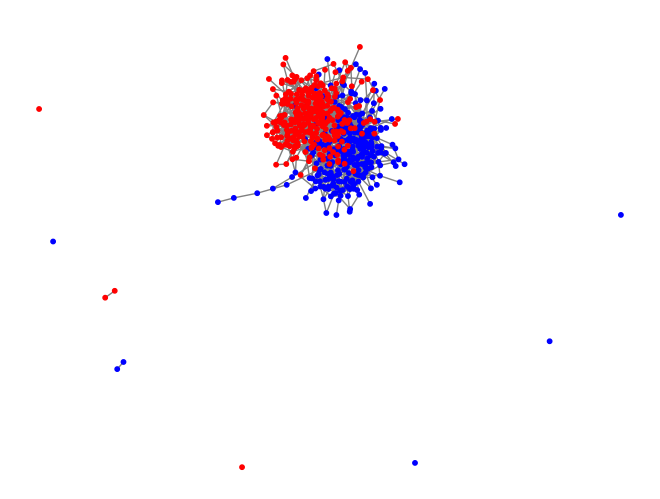

In [9]:
n = 600  # Number of nodes

# Between 0 and 2
alpha_s = 1.8
G = create_network(n, alpha_s)

print("Number of nodes in the network:", G.number_of_nodes())
print("Number of edges in the network:", G.number_of_edges())

# Convert 'wing' attribute values to colors
node_colors_G = ['blue' if G.nodes[node]['wing'] == 'left' else 'red' for node in G.nodes()]

# Plot the graph with colors based on the "wing" attribute
nx.draw(G, node_color=node_colors_G, node_size=10, edge_color='gray')

In [24]:
def misinfo_spread(G, pi_left, pi_right, mis_count_scale = 1, missing_count=True, info=True):
    
    # Make a copy so we don't effect original graph
    G_new = G.copy()
    
    # Determine whether nodes are active based on pi
    for node in G_new.nodes:
        if G_new.nodes[node]['wing'] == 'left':
            if random.random() < pi_left:
                G_new.nodes[node]['active'] = False
            else:
                G_new.nodes[node]['active'] = True
        elif G_new.nodes[node]['wing'] == 'right':
            if random.random() < pi_right:
                G_new.nodes[node]['active'] = False
            else:
                G_new.nodes[node]['active'] = True
                
    
    infected_nodes = set()
    t = 0
    mis_count = 0
    
    # Set all nodes as uninfected
    for node in G_new.nodes():
        G_new.nodes[node]['infected'] = False
    
    
    # Choose one node with wing='right' from the largest component to randomly to start the spread
    connected_components = list(nx.connected_components(G_new))
    largest_component = max(connected_components, key=len)
    random_right_node = random.choice([node for node, attrs in G_new.nodes(data=True) if (node in largest_component) and (attrs['wing'] == 'right') and (attrs['active'] == True)])
    infected_nodes.add(random_right_node)
    G_new.nodes[random_right_node]['infected'] = True
    
    
    # Iterate over time periods until no new person spreads fake news
    new_infections = set()
    new_infections.add(random_right_node)
    mis_count_nodes = set()
    
    while True:
        t += 1

        # Defining sets as new_infections cannot be updated during the loop
        nodes_to_remove = set()
        nodes_to_add = set()
        
        # Iterate over infected nodes and infect their neighbors if they are active
        for node in new_infections:
            # Remove node from infections so each node only has one chance to spread fake news
            nodes_to_remove.add(node)
            for neighbor in G_new.neighbors(node):
                if neighbor not in infected_nodes and neighbor not in new_infections:
                    if G_new.nodes[neighbor]['active'] == True:
                        if missing_count:
                            # Reduce infection probability based on proportion of missing count clicks
                            count_proportion = mis_count/len(G_new)
                            if random.random() > count_proportion * mis_count_scale:
                                G_new.nodes[neighbor]['infected'] = True
                                nodes_to_add.add(neighbor)
                            else:
                                # DO I NEED TO CHECK THIS, SHOULD THEY BE ABLE TO GET HERE IF THEY ARE IN MIS_COUNT_NODES
                                # I SHOULDN'T NEED THIS IF CONDITION, CHECK IF IT AFFECTS THE GRAPHS IN ANY WAY!
                                if neighbor not in mis_count_nodes:
                                    mis_count += 1
                                    mis_count_nodes.add(neighbor)
                                    # After adding to missing count the node becomes inactive
                                    G_new.nodes[neighbor]['active'] = False
                        else:
                            G_new.nodes[neighbor]['infected'] = True
                            nodes_to_add.add(neighbor)
                    elif missing_count:
                        # If neighbor is not active then they add to the missing count
                        if neighbor not in mis_count_nodes:
                            mis_count += 1
                            mis_count_nodes.add(neighbor)
        
        # Remove all nodes which have shared fake news (as only one shot to infect)                
        new_infections.difference_update(nodes_to_remove)
        new_infections.update(nodes_to_add)
        infected_nodes.update(nodes_to_add)
                              
        if not new_infections:
            break
            
    
    if info:
        print("Simulation lasted " + str(t) + " periods")
        if missing_count:
            print("Missing count at end of simulation: " + str(mis_count))
            print("Missing count (proportion of network): " + str(mis_count/len(G_new)))
        print("Number of people sharing fake news: " + str(len(infected_nodes)))
        print("Proportion of people sharing fake news: " + str(len(infected_nodes)/len(G_new)))
        
    return G_new


Note in the above the chosen node to start the infection will always be from the giant component

Note that when someone adds to the missing count they become inactive!

WHY CAN THE PROPORTION OF PEOPLE ADDING TO THE MISSING COUNT AND THE PEOPLE SHARING FAKE NEWS ADD TO MORE THAN ONE?
Must mean people are either sharing fake news then adding to the missing count later...?

In [7]:
# Simulate misinfo spread
G_sim = misinfo_spread(G, 0.7, 0.2, missing_count=True)

Simulation lasted 11 periods
Missing count at end of simulation: 197
Missing count (proportion of network): 0.3283333333333333
Number of people sharing fake news: 241
Proportion of people sharing fake news: 0.40166666666666667


In [38]:
common_elements = mis_count_nodes & infected_nodes
len(common_elements)

251

In [38]:
G_sim.nodes(data=True)

NodeDataView({0: {'block': 0, 'wing': 'left', 'active': True, 'infected': True}, 1: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 2: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 3: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 4: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 5: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 6: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 7: {'block': 0, 'wing': 'left', 'active': True, 'infected': True}, 8: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 9: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 10: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 11: {'block': 0, 'wing': 'left', 'active': True, 'infected': True}, 12: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 13: {'block': 0, 'wing': 'left', 'active': False, 'infected': False}, 14: {'block': 0, 'wing

In [25]:
# Function to calculate the reach of misinformation
def reach(G):
    nodes_reached = set()
    for node in G.nodes():
    # Check if the node has the specific attribute
        if G.nodes[node]['infected'] == True:
            neighbors = G.neighbors(node)
            nodes_reached.add(node)
            nodes_reached.update(neighbors)
            
    return len(nodes_reached)

In [26]:
# Function to calculate the influence of misinformation
def influence(G):
    nodes_influenced = 0
    for node in G.nodes():
        if G.nodes[node]['wing'] == 'left' and G.nodes[node]['infected'] == True:
            nodes_influenced += 1
            
    return nodes_influenced

In [27]:
# For a given graph, sim the misinformation spread and calculate the difference in reach and influence
def pol_effect(G, pi_left, pi_right, mis_count_scale):
    G_pol = misinfo_spread(G, pi_left, pi_right, mis_count_scale, missing_count=True, info=False)
    G_no_pol = misinfo_spread(G, pi_left, pi_right, mis_count_scale, missing_count=False, info=False)
    
    reach_diff = reach(G_no_pol) - reach(G_pol)
    influence_diff = influence(G_no_pol) - influence(G_pol)
    
    return reach_diff, influence_diff

In [23]:
reach_diff, influence_diff = pol_effect(G, 0.7, 0.2)
print(reach_diff)
print(influence_diff)

0
9


In [41]:
# Plot different levels of alpha the effectivness of the policy
import numpy as np
from statistics import mean

def vary_alpha(pi_left, pi_right, mis_count_scale):
    alpha_list = []
    reach_list = []
    influence_list = []

    for alpha in np.arange(1, 2, 0.05):
        # Generate graph 10 times for each alpha to average over
        for i in range(100):
            local_reach_list = []
            local_influence_list = []
            G = create_network(1000, alpha)

            # See effectiveness of policy
            reach_diff, influence_diff = pol_effect(G, pi_left, pi_right, mis_count_scale)

            # Add to lists for plotting
            local_reach_list.append(reach_diff)
            local_influence_list.append(influence_diff)
            
        alpha_list.append(alpha)
        reach_list.append(mean(local_reach_list))
        influence_list.append(mean(local_influence_list))
        
    return alpha_list, reach_list, influence_list


In [31]:
# Run function
alpha_list, reach_list, influence_list = vary_alpha(0.8, 0.2, 1)

[500, 500]
0.006666666666666667
0.006666666666666667
[500, 500]
0.006666666666666667
0.006666666666666667
[500, 500]
0.006666666666666667
0.006666666666666667
[500, 500]
0.006666666666666667
0.006666666666666667
[500, 500]
0.006666666666666667
0.006666666666666667
[500, 500]
0.007000000000000001
0.006333333333333333
[500, 500]
0.007000000000000001
0.006333333333333333
[500, 500]
0.007000000000000001
0.006333333333333333
[500, 500]
0.007000000000000001
0.006333333333333333
[500, 500]
0.007000000000000001
0.006333333333333333
[500, 500]
0.007333333333333334
0.006
[500, 500]
0.007333333333333334
0.006
[500, 500]
0.007333333333333334
0.006
[500, 500]
0.007333333333333334
0.006
[500, 500]
0.007333333333333334
0.006
[500, 500]
0.007666666666666668
0.005666666666666666
[500, 500]
0.007666666666666668
0.005666666666666666
[500, 500]
0.007666666666666668
0.005666666666666666
[500, 500]
0.007666666666666668
0.005666666666666666
[500, 500]
0.007666666666666668
0.005666666666666666
[500, 500]
0.00

In [35]:
# Plot function

def plot_alpha_vary(alpha_list, reach_list, influence_list):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Level of homophily')
    ax1.set_ylabel('Policy reduction on reach', color=color)
    ax1.plot(alpha_list, reach_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.set_ylabel('Policy reduction on influence', color=color)
    ax2.plot(alpha_list, influence_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.grid(True)

    plt.show()

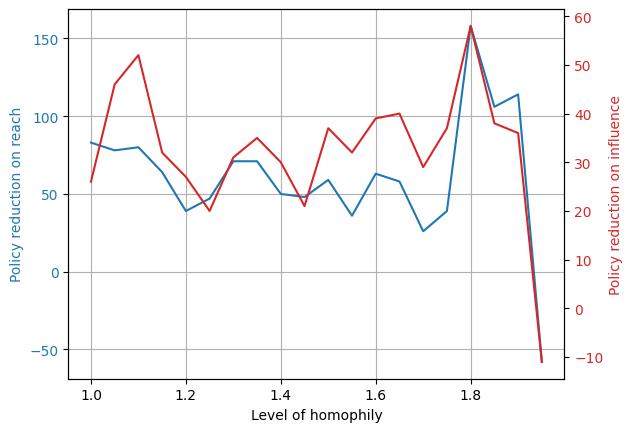

In [34]:
plot_alpha_vary(alpha_list, reach_list, influence_list)

Params we can alter:
- the original infection p (currently 0.01)
- the effectivness of the policy
- the values of pi

Loop changing the effectiveness of the policy, and the levels of pi, to see if for this graph set up we can achieve any sensible results

Left pi: 0.95 Right pi: 0.05
Missing count scale: 1


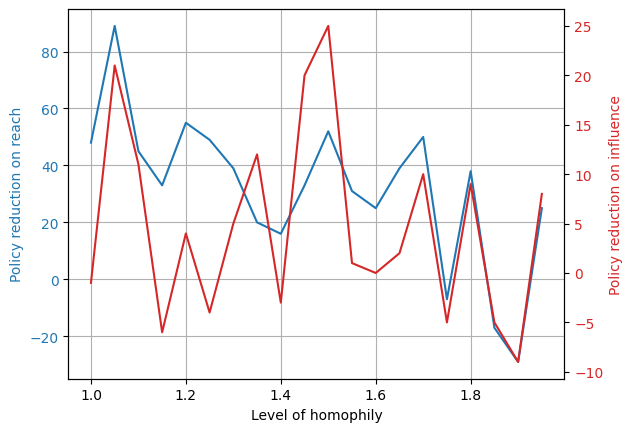

Left pi: 0.95 Right pi: 0.05
Missing count scale: 1.2


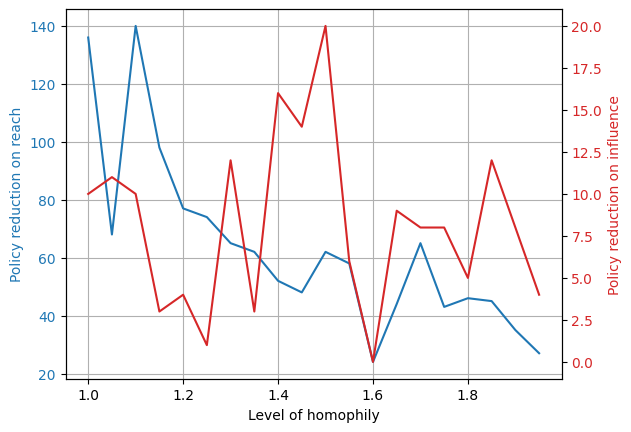

Left pi: 0.95 Right pi: 0.05
Missing count scale: 1.5


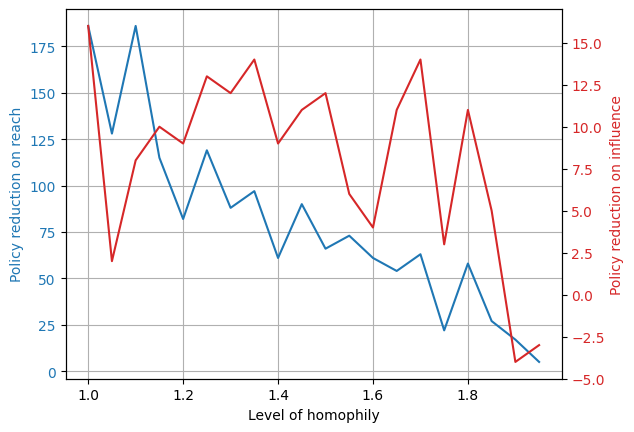

Left pi: 0.95 Right pi: 0.05
Missing count scale: 1.7


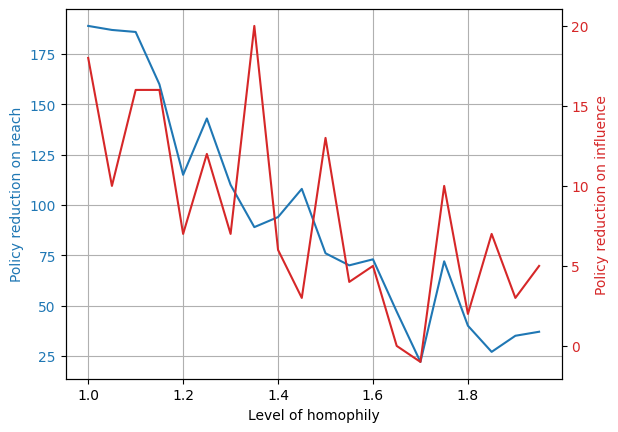

Left pi: 0.8 Right pi: 0.2
Missing count scale: 1


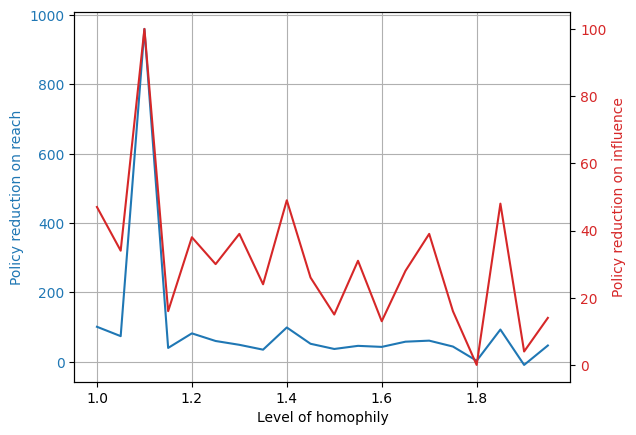

Left pi: 0.8 Right pi: 0.2
Missing count scale: 1.2


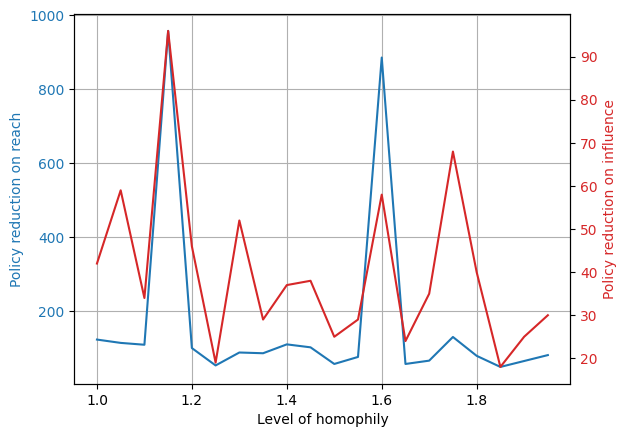

Left pi: 0.8 Right pi: 0.2
Missing count scale: 1.5


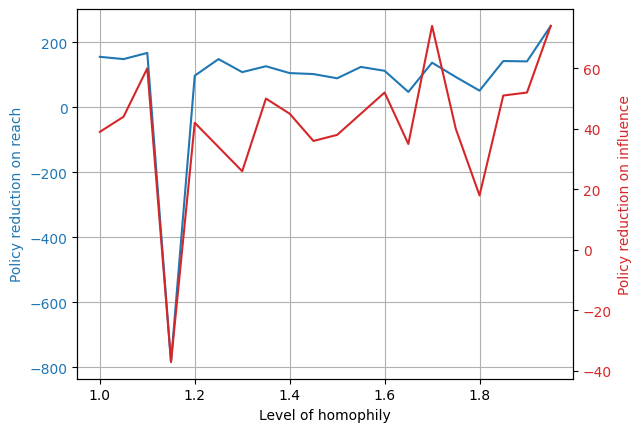

Left pi: 0.8 Right pi: 0.2
Missing count scale: 1.7


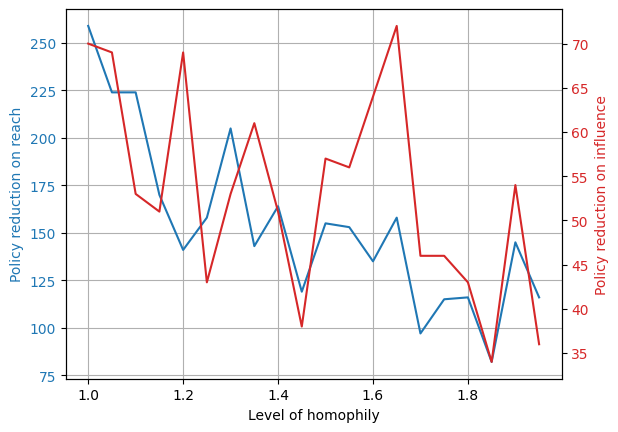

Left pi: 0.6 Right pi: 0.4
Missing count scale: 1


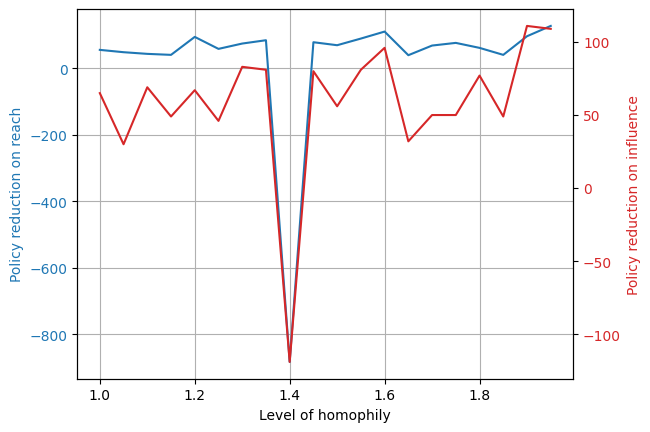

Left pi: 0.6 Right pi: 0.4
Missing count scale: 1.2


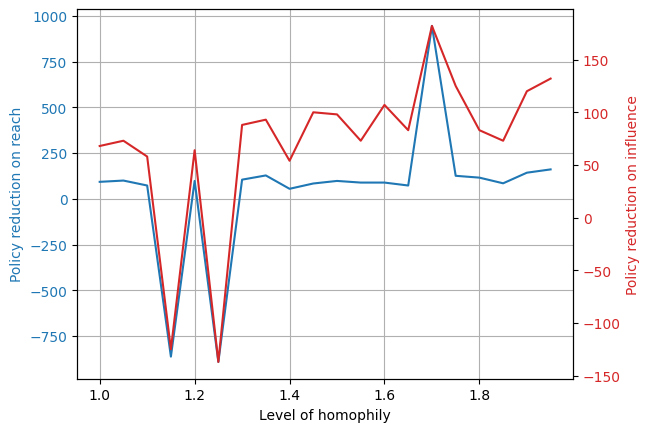

Left pi: 0.6 Right pi: 0.4
Missing count scale: 1.5


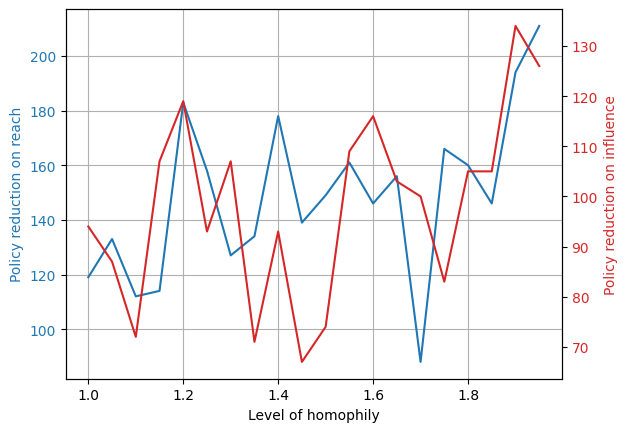

Left pi: 0.6 Right pi: 0.4
Missing count scale: 1.7


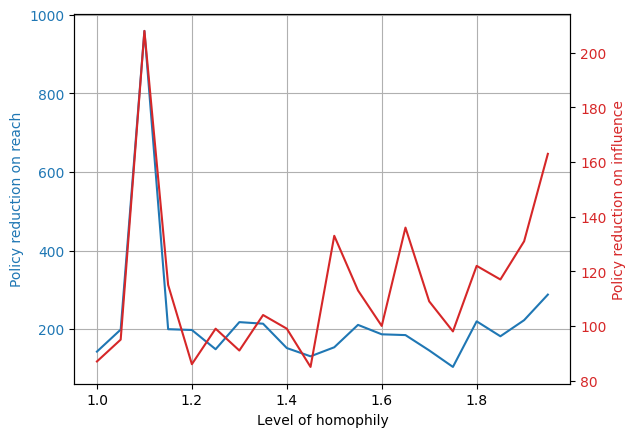

In [42]:
pi_try = [[0.95, 0.05], [0.8, 0.2], [0.6, 0.4]]

scales = [1, 1.2, 1.5, 1.7]

for pi in pi_try:
    for scale in scales:
        alpha_list, reach_list, influence_list = vary_alpha(pi[0], pi[1], scale)
        print("Left pi: " + str(pi[0]) +" Right pi: " + str(pi[1]))
        print("Missing count scale: " + str(scale))
        plot_alpha_vary(alpha_list, reach_list, influence_list)
        
        